# Multi-step forecasting: direct approach

In the previous notebooks, we forecasted one step ahead; that is, the pollutant concentration for the next hour.

In this notebook, we will predict the hourly pollutant concentration for the next 24 hours. That is, we will forecast 24 steps ahead (multi-step forecasting)

We will carry out multi-step forecasting using a direct approach.

## Data

We will work with the Air Quality Dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Air+Quality).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 3, in the folder "01-Datasets" from this repo.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from feature_engine.creation import (
    CyclicalFeatures,
    MathFeatures,
)
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

# Load data

In [2]:
# We carry out all data preparation steps from the
# notebook in section 2 within a function.

def load_data():

    # Data lives here.
    filename = "../datasets/AirQualityUCI_ready.csv"

    # Load data: only the time variable and CO.
    data = pd.read_csv(
        filename,
        usecols=["Date_Time", "CO_sensor"],
        parse_dates=["Date_Time"],
        index_col=["Date_Time"],
    )

    # Sanity: sort index.
    data.sort_index(inplace=True)

    # Reduce data span.
    data = data["2004-04-01":"2005-04-30"]

    # Remove outliers
    data = data.loc[(data["CO_sensor"] > 0)]

    return data

In [3]:
# Load data.

data = load_data()

data.head()

,CO_sensor
Date_Time,
2004-04-04 00:00:00,1224.0
2004-04-04 01:00:00,1215.0
2004-04-04 02:00:00,1115.0
2004-04-04 03:00:00,1124.0
2004-04-04 04:00:00,1028.0


# Our feature engineering class

In [4]:
class SeasonalTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, season_var, variables):

        # In the init we specify the parameters that
        # the user needs to pass to start the transformer.

        # The user needs to indicate the seasonal variable
        # and the variables that should be aggregated.

        self.season_var = season_var
        self.variables = variables

    def fit(self, X, y=None):

        # We want to estimate the mean value of the
        # time series in the seasonal term.

        # In our demo, that is the mean pollutant's
        # concentration per hour.

        # We make a copy of the dataframe
        # not to over-write the user's data.
        X = X.copy()

        # Calculate mean pollutant per hr.
        # The learned values will be stored in this attribute.
        self.seasonal_ = X.groupby(self.season_var)[self.variables].mean()

        # Rename the new variables.
        self.seasonal_.columns = [v + "_season" for v in self.variables]

        # Reset index
        self.seasonal_ = self.seasonal_.reset_index()

        return self

    def transform(self, X):

        # Add the seasonal component to the
        # dataset to transform.

        X = X.copy()

        # Store the datetime index (it is lost in merge)
        index = X.index

        # Add the seasonal feature.
        X = X.merge(self.seasonal_, on=self.season_var, how="left")

        # Restore the datetime index to the df
        X.index = index

        # Drop input variable
        X = X.drop(self.variables, axis=1)

        return X

# Feature engineering steps

The same pipeline from the previous notebook.

In [5]:
# Datetime features
dtf = DatetimeFeatures(
    # the input dt variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
        "week",
        "day_of_week",
        "day_of_month",
        "hour",
        "weekend",
    ],
)

In [6]:
# Lag features.

lagf = LagFeatures(
    variables="CO_sensor",  # the input variable
    freq=["1H", "24H"],  # move 1 hr and 24 hrs forward
    missing_values="ignore",
)

In [7]:
# Window features

winf = WindowFeatures(
    variables="CO_sensor",  # the input variable
    window="3H",  # average of 3 previous hours
    freq="1H",  # move 1 hr forward
    missing_values="ignore",
)

In [8]:
# Feature combination

combine = MathFeatures(
    # the variables to combine
    variables=["CO_sensor_lag_1H", "CO_sensor_lag_24H"],
    
    # we indicate we want the average
    func=["mean"],
    
    # the name of the new feature
    new_variables_names=["CO_lag_ave"],
    
    # what to do if the variables have NA
    missing_values="ignore",
)

In [9]:
# Periodic features

cyclicf = CyclicalFeatures(
    
    # The features we want to transform.
    variables=["month", "hour"],
    
    # Whether to drop the original features.
    drop_original=False,
)

In [10]:
# Drop missing data
imputer = DropMissingData()

In [11]:
# Seasonal feature

seasonf = SeasonalTransformer(
    
    # the seasonal variable
    season_var="hour",
    
    # the time series
    variables=["CO_sensor"],
)

# Feature engineering pipeline

In [12]:
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("combine", combine),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("seasonal", seasonf),
    ]
)

# Split data into train and test

We will leave the last month of data as hold-out sample to evaluate the performance of the model.

Remember that we need data about the pollutant information at least 24 hours before to create the input features for the first day of the test set.

In [13]:
# Split the data.

# input data
X_train = data[data.index < "2005-03-04"]
X_test = data[data.index >= pd.Timestamp("2005-03-04") - pd.offsets.Hour(24)]

# target
y_train = data[data.index < "2005-03-04"]["CO_sensor"]
y_test = data[data.index >= pd.Timestamp(
    "2005-03-04") - pd.offsets.Hour(24)]["CO_sensor"]

# Prepare the target

In the direct approach, we build a model to predict each one of the steps in the forecasting horizon.

This means that we need to create suitable targets first:

- 1 hour ahead
- 2 hour ahead
- 3 hour ahead

...

- 24 hour ahead.

In [14]:
# The forecasting horizon.
horizon = 24

# Create an empty dataframe for the new targets.
y_train_multi = pd.DataFrame(index=y_train.index)
y_test_multi = pd.DataFrame(index=y_test.index)

# Add each one of the steps ahead.
for h in range(horizon):
    y_train_multi[f"h_{h}"] = y_train.shift(periods=-h, freq="H")
    y_test_multi[f"h_{h}"] = y_test.shift(periods=-h, freq="H")

In [15]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y_train_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2004-04-04 00:00:00,1224.0,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,...,1136.0,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0
2004-04-04 01:00:00,1215.0,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,...,1296.0,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0
2004-04-04 02:00:00,1115.0,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,...,1345.0,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0
2004-04-04 03:00:00,1124.0,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,...,1296.0,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0
2004-04-04 04:00:00,1028.0,1010.0,1074.0,1034.0,1130.0,1275.0,1324.0,1268.0,1272.0,1160.0,...,1258.0,1420.0,1366.0,1113.0,1196.0,1188.0,1065.0,999.0,911.0,873.0


In [16]:
# Each column represents one of the targets.
# Each target represents the number of steps ahead.

y_test_multi.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
Date_Time,,,,,,,,,,,,,,,,,,,,,
2005-03-03 00:00:00,1047.0,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,...,1096.0,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0
2005-03-03 01:00:00,1030.0,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,...,1108.0,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0
2005-03-03 02:00:00,986.0,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,...,1124.0,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0
2005-03-03 03:00:00,992.0,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,...,1216.0,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0,938.0
2005-03-03 04:00:00,1076.0,1104.0,1160.0,1217.0,1457.0,1337.0,1111.0,1165.0,1129.0,1092.0,...,1437.0,1473.0,1396.0,1285.0,1206.0,1179.0,929.0,951.0,938.0,921.0


When we create our target, we will add some missing data because we obviously don't have all the information that far ahead.

In [17]:
y_train_multi.isnull().sum()

h_0       0
h_1      25
h_2      46
h_3      67
h_4      87
h_5     106
h_6     124
h_7     142
h_8     160
h_9     177
h_10    193
h_11    210
h_12    227
h_13    244
h_14    261
h_15    277
h_16    293
h_17    309
h_18    325
h_19    340
h_20    355
h_21    370
h_22    385
h_23    400
dtype: int64

In [18]:
y_test_multi.isnull().sum()

h_0      0
h_1      3
h_2      6
h_3      9
h_4     12
h_5     15
h_6     18
h_7     21
h_8     24
h_9     27
h_10    30
h_11    33
h_12    36
h_13    39
h_14    42
h_15    45
h_16    48
h_17    51
h_18    54
h_19    57
h_20    60
h_21    63
h_22    66
h_23    69
dtype: int64

In [19]:
# Let's drop the missing data points in the
# target and adjust our training and testing sets.

y_train_multi.dropna(inplace=True)
y_test_multi.dropna(inplace=True)

X_train = X_train.loc[y_train_multi.index]
X_test = X_test.loc[y_test_multi.index]

# Train pipeline and model

We train the engineering steps and the pipeline utilizing the training set.

In [20]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2004-04-05 00:00:00,4,15,0,5,0,0,1188.0,1224.0,1165.666667,1206.0,0.866025,-0.5,0.000000,1.000000,1039.940239
2004-04-05 01:00:00,4,15,0,5,1,0,1065.0,1215.0,1149.666667,1140.0,0.866025,-0.5,0.269797,0.962917,976.735294
2004-04-05 02:00:00,4,15,0,5,2,0,999.0,1115.0,1084.000000,1057.0,0.866025,-0.5,0.519584,0.854419,916.422594
2004-04-05 03:00:00,4,15,0,5,3,0,911.0,1124.0,991.666667,1017.5,0.866025,-0.5,0.730836,0.682553,878.037500
2004-04-05 04:00:00,4,15,0,5,4,0,873.0,1028.0,927.666667,950.5,0.866025,-0.5,0.887885,0.460065,861.344398


In [21]:
# Our transformation pipeline removed observations
# with missing data, so we need to remove those
# observations from the target variable as well.

print(y_train.shape)

y_train_t = y_train_multi.loc[X_train_t.index]

print(y_train_t.shape)

(6850,)
(5769, 24)


In [22]:
# Lasso regression

# Using the MultiOutputRegressor, we automatically create
# one Lasso for each target.

lasso = MultiOutputRegressor(Lasso(random_state=0, max_iter=50000))

# Train the model

lasso.fit(X_train_t, y_train_t)

MultiOutputRegressor(estimator=Lasso(max_iter=50000, random_state=0))

In [23]:
# Make predictions

preds = lasso.predict(X_train_t)

# The predictions are made for each one of
# the targets.

preds.shape

(5769, 24)

In [24]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_train_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1156.688721,1078.457980,1010.437903,976.830345,996.446226,1050.649912,1126.974183,1188.739754,1173.208440,1104.850955,...,1173.539656,1219.087048,1252.071626,1266.458700,1238.065912,1174.801018,1104.484638,1064.223113,1076.856379,1097.191911
1,1030.320949,990.965530,962.201600,958.264423,990.765453,1049.189968,1121.725733,1181.291328,1179.027817,1133.792596,...,1166.531684,1195.170622,1223.381533,1238.696269,1220.109350,1179.422797,1132.366926,1090.103882,1058.827880,1028.518724
2,963.393542,952.601655,963.463364,989.760726,1031.233206,1080.730118,1132.146824,1170.472571,1171.244667,1145.717815,...,1162.820810,1182.584423,1201.218256,1210.359578,1195.639018,1161.649864,1117.711703,1068.331218,1016.184038,966.411469
3,893.609509,917.917190,963.915928,1013.172244,1059.164566,1098.459253,1129.662822,1148.720612,1151.806820,1142.748256,...,1149.929918,1160.780318,1169.643068,1170.486851,1155.018724,1123.532572,1080.114804,1024.392042,958.393077,902.277292
4,863.074536,906.326955,975.369742,1040.928585,1089.013605,1118.544770,1132.418369,1134.866451,1138.921744,1143.390517,...,1133.334945,1134.672263,1132.662475,1125.545735,1111.076931,1083.733250,1044.239278,991.011783,925.421958,872.223452


In [25]:
# The RMSE in the train set.

for h in range(horizon):
    colname = f"h_{h}"
    rmse = mean_squared_error(preds[f"h_{h}"], y_train_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 92.52761292077068
for horizon 1 got rmse: 138.89474068654363
for horizon 2 got rmse: 161.95858962957152
for horizon 3 got rmse: 168.58249221232967
for horizon 4 got rmse: 168.5760014608411
for horizon 5 got rmse: 167.22185968936975
for horizon 6 got rmse: 164.10739098076175
for horizon 7 got rmse: 162.6224619157321
for horizon 8 got rmse: 170.62210863327692
for horizon 9 got rmse: 175.65894990396623
for horizon 10 got rmse: 174.2565572483238
for horizon 11 got rmse: 173.0400950060773
for horizon 12 got rmse: 175.34836336422228
for horizon 13 got rmse: 180.1979913529479
for horizon 14 got rmse: 184.8169691842251
for horizon 15 got rmse: 187.0373327071194
for horizon 16 got rmse: 185.94092478677703
for horizon 17 got rmse: 182.11573909565948
for horizon 18 got rmse: 179.2948128404489
for horizon 19 got rmse: 178.08454319026941
for horizon 20 got rmse: 174.9232575635553
for horizon 21 got rmse: 171.93140741779246
for horizon 22 got rmse: 172.188718106189
for horizo

Notice how the RMSE is worse for those values further into the future. This is normal; predictions about the furthest values in the future always have a greater uncertainty.

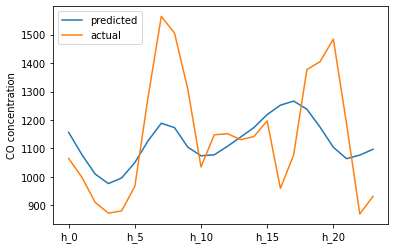

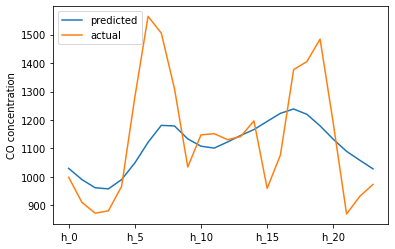

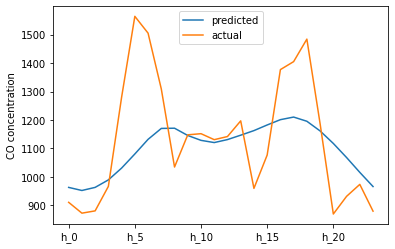

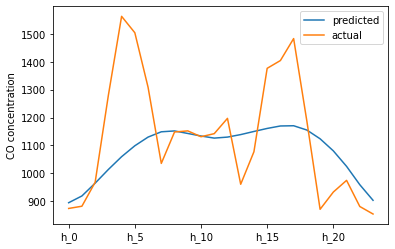

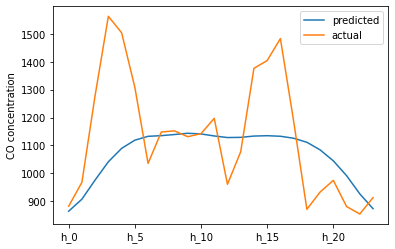

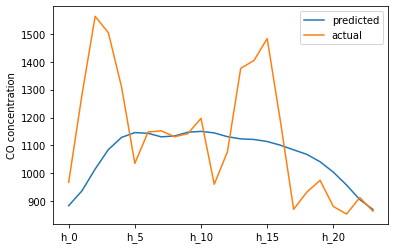

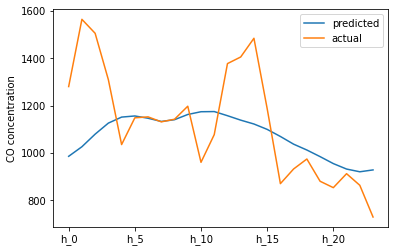

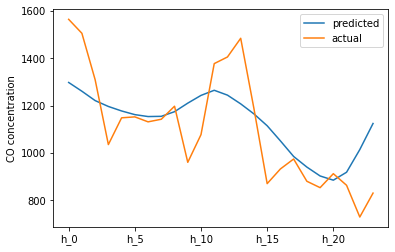

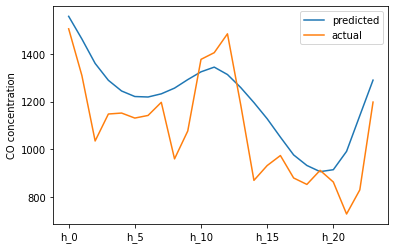

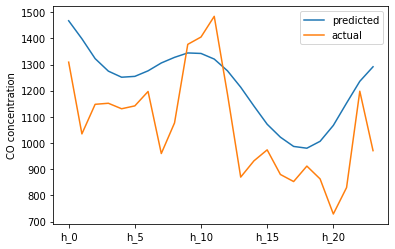

In [26]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat([
        preds.iloc[i].T,
        y_train_t.iloc[i].T,
    ], axis=1)
    
    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

Our model managed to get the trend of the forecast, but deviates from the real values quite a bit.

Hopefully, by the end of the course we can improve this model with more useful features :)

# Forecast 24 hours ahead in test set

We will evaluate the performance of the model in our test set now.

In [27]:
# Create the input features:

X_test_t = pipe.transform(X_test)

X_test_t.head()

,month,week,day_of_week,day_of_month,hour,weekend,CO_sensor_lag_1H,CO_sensor_lag_24H,CO_sensor_window_3H_mean,CO_lag_ave,month_sin,month_cos,hour_sin,hour_cos,CO_sensor_season
Date_Time,,,,,,,,,,,,,,,
2005-03-04 00:00:00,3,9,4,4,0,0,1179.0,1047.0,1223.333333,1113.0,1.0,6.123234e-17,0.000000,1.000000,1039.940239
2005-03-14 00:00:00,3,11,0,14,0,0,1207.0,1017.0,1201.333333,1112.0,1.0,6.123234e-17,0.000000,1.000000,1039.940239
2005-03-14 01:00:00,3,11,0,14,1,0,1056.0,1050.0,1157.000000,1053.0,1.0,6.123234e-17,0.269797,0.962917,976.735294
2005-03-14 02:00:00,3,11,0,14,2,0,1128.0,1023.0,1130.333333,1075.5,1.0,6.123234e-17,0.519584,0.854419,916.422594
2005-03-14 03:00:00,3,11,0,14,3,0,1119.0,940.0,1101.000000,1029.5,1.0,6.123234e-17,0.730836,0.682553,878.037500


In [28]:
# Make predictions

preds = lasso.predict(X_test_t)

preds.shape

(426, 24)

In [29]:
print(y_test_multi.shape)

# Adjust the target, it has observations
# that were removed from the test set due
# to null values.

y_test_t = y_test_multi.loc[X_test_t.index]

print(y_test_t.shape)

(498, 24)
(426, 24)


In [30]:
# Let's capture the predictions in a dataframe
# to determine the RMSE and plot the results.

preds = pd.DataFrame(preds, columns=y_test_t.columns)

preds.head()

,h_0,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,...,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21,h_22,h_23
0,1119.360788,1034.081352,965.958409,940.176867,968.946413,1037.317538,1129.542775,1205.729882,1193.480543,1123.745989,...,1167.273374,1205.753672,1240.391379,1260.352157,1238.956034,1192.867196,1143.094729,1110.045080,1109.868318,1102.746162
1,1154.836861,1066.517294,997.460995,968.109448,992.693314,1053.159989,1136.577050,1204.910369,1192.452087,1126.181053,...,1182.402694,1225.564907,1259.437721,1277.873303,1256.644700,1203.006522,1142.838152,1110.063471,1122.211176,1131.755518
2,1010.206038,967.876452,941.214188,942.030351,979.129582,1042.906453,1121.256820,1186.337860,1186.863506,1143.576842,...,1171.634546,1198.967743,1228.351362,1246.766580,1233.038241,1198.995299,1158.599049,1120.542365,1087.561368,1049.242544
3,1074.957855,1040.154260,1042.506925,1065.709725,1103.078007,1143.172475,1183.506528,1210.315580,1206.005044,1180.428479,...,1203.983145,1227.786777,1241.748939,1245.671665,1229.443052,1188.050874,1134.084180,1085.921053,1053.006681,1021.875916
4,1062.142328,1043.878489,1073.304708,1117.551559,1159.085951,1188.660383,1208.836250,1215.870818,1213.230548,1204.245360,...,1203.716294,1217.231580,1219.823849,1216.140645,1203.130788,1168.306733,1119.513407,1071.552530,1030.997001,992.006639


In [31]:
# The RMSE in the test set.

for h in range(horizon):
    colname = f"h_{h}"
    rmse = mean_squared_error(preds[f"h_{h}"], y_test_t[f"h_{h}"], squared=False)
    print(f"for horizon {h} got rmse: {rmse}")

for horizon 0 got rmse: 90.92373669198722
for horizon 1 got rmse: 148.4121634440391
for horizon 2 got rmse: 187.34647468930876
for horizon 3 got rmse: 195.71010070780935
for horizon 4 got rmse: 187.0550505523515
for horizon 5 got rmse: 176.2475177582505
for horizon 6 got rmse: 164.9174993304005
for horizon 7 got rmse: 153.4414963313835
for horizon 8 got rmse: 152.15742917860376
for horizon 9 got rmse: 161.27219138367008
for horizon 10 got rmse: 156.87076901166014
for horizon 11 got rmse: 152.1607345765715
for horizon 12 got rmse: 155.39592287085318
for horizon 13 got rmse: 166.39342645630208
for horizon 14 got rmse: 178.5213096897498
for horizon 15 got rmse: 185.75402405345505
for horizon 16 got rmse: 185.91990537932236
for horizon 17 got rmse: 179.38977279644186
for horizon 18 got rmse: 170.43233534730828
for horizon 19 got rmse: 166.19293248197462
for horizon 20 got rmse: 156.8479268080091
for horizon 21 got rmse: 141.39105674936803
for horizon 22 got rmse: 142.1391044252031
for hori

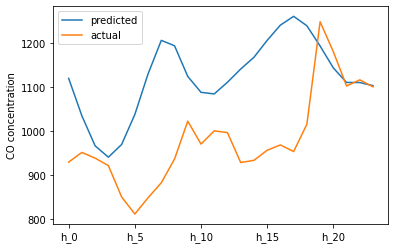

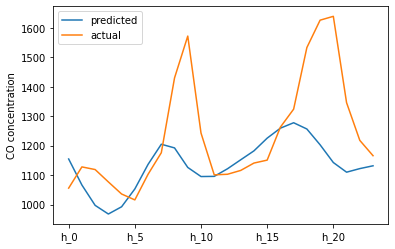

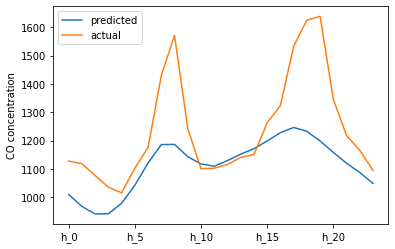

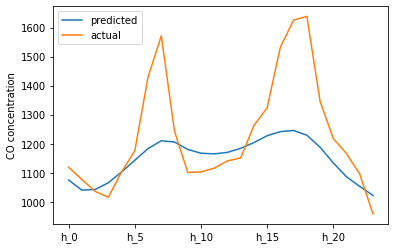

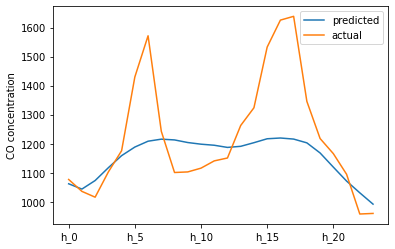

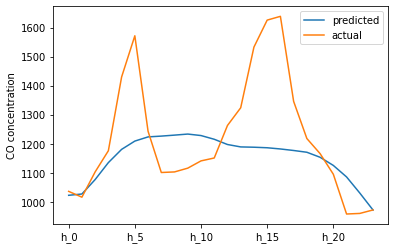

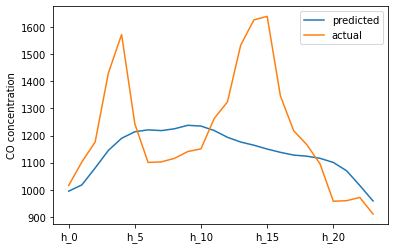

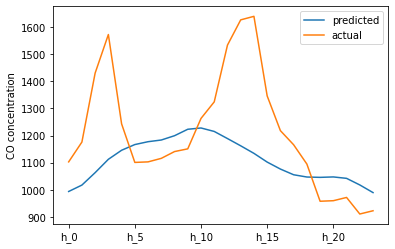

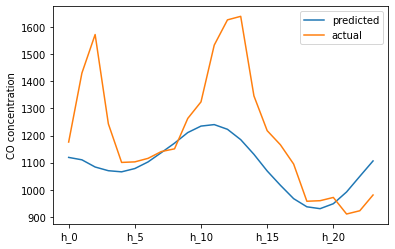

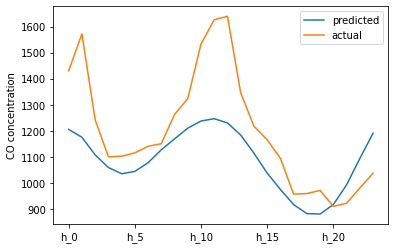

In [32]:
# Let's plot the first ten multistep forecasts
# in the train set.

# Each row corresponds to 24 hr forecasts.

for i in range(0, 10):
    tmp = pd.concat([
        preds.iloc[i].T,
        y_test_t.iloc[i].T,
    ], axis=1)
    
    tmp.columns = ["predicted", "actual"]

    tmp.plot()
    plt.ylabel("CO concentration")
    plt.show()

We've seen how to implement the direct forecasting method to perform multistep forecasting.